In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

## Download the flower_photos dataset

Load the dataset

In [2]:
import requests
url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# url = "http://www.kasprowski.pl/yanshan/flowers.tgz"
r = requests.get(url, allow_redirects=True)
open('flowers.tgz', 'wb').write(r.content)
print("Downloaded to flowers.tgz")

Downloaded to flowers.tgz


Unzip the file

In [3]:
import tarfile
tar = tarfile.open('flowers.tgz', "r:gz")
tar.extractall()
tar.close()
print("Uzipped to /flower_photos directory")

Uzipped to /flower_photos directory


## Load images

In [15]:
import cv2
import os
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        the_class = class_dir
        if not os.path.isfile(indir+'/'+class_dir):
            for file in os.listdir(indir+'/'+class_dir):
                image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (64,64))
                samples.append(image)
                labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels
samples, labels = load_img('flower_photos')
print('loaded',len(samples),' samples')
print('classes',set(labels))
org_samples = samples
org_labels = labels

loaded 3670  samples
classes {'sunflowers', 'dandelion', 'roses', 'daisy', 'tulips'}


## Show examples

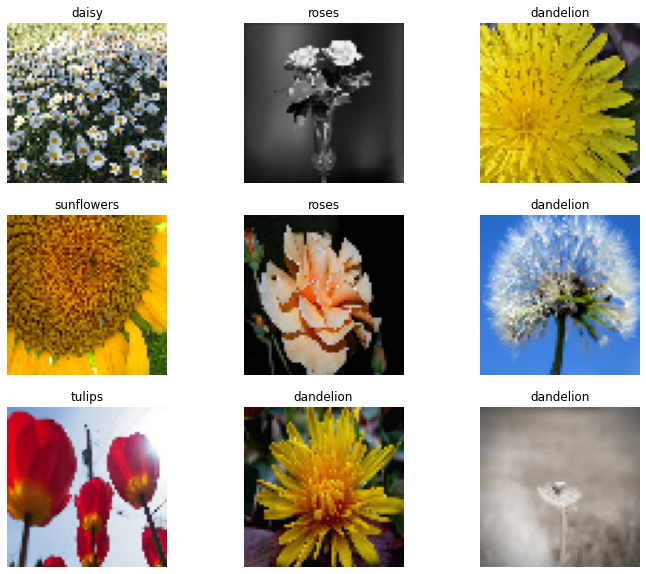

In [16]:
import matplotlib.pyplot as plt
import random
    
plt.figure(figsize=(12, 10))
for i in range(9):
    n = random.randrange(len(samples))
    plt.subplot(3, 3, i + 1)
    plt.imshow(samples[n])
    plt.title(labels[n])
    plt.axis("off")

## Create a simple ANN model

In [17]:
model = Sequential()
model.add(Dense(50, input_dim=12288, activation='sigmoid'))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                614450    
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 255       
Total params: 619,805
Trainable params: 619,805
Non-trainable params: 0
_________________________________________________________________


## Flatten samples

In [18]:
samples = org_samples
labels = org_labels
print("Samples shape before",samples.shape)

# flatten samples
samples = np.reshape(samples,newshape=(3670,-1))
print("Samples shape flattened",samples.shape)

Samples shape before (3670, 64, 64, 3)
Samples shape flattened (3670, 12288)


## One-hot labels

In [19]:
# one-hot labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("Labels shape",labels.shape)
labels = labels.astype(float)

Labels shape (3670, 5)


## Train model

In [20]:
print(samples.shape)
import sklearn.model_selection
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,random_state=22)
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

(3670, 12288)


In [23]:
H = model.fit(trainSamples, trainLabels, epochs=10, validation_data=(testSamples,testLabels))    

Epoch 1/10
86/86 [==============================] - 1s 7ms/step - loss: 1.6037 - accuracy: 0.2478 - val_loss: 1.6023 - val_accuracy: 0.2353
Epoch 2/10
86/86 [==============================] - 1s 8ms/step - loss: 1.6025 - accuracy: 0.2431 - val_loss: 1.6084 - val_accuracy: 0.2353
Epoch 3/10
86/86 [==============================] - 1s 6ms/step - loss: 1.6051 - accuracy: 0.2478 - val_loss: 1.6039 - val_accuracy: 0.2353
Epoch 4/10
86/86 [==============================] - 1s 7ms/step - loss: 1.6036 - accuracy: 0.2391 - val_loss: 1.6021 - val_accuracy: 0.2353
Epoch 5/10
86/86 [==============================] - 1s 9ms/step - loss: 1.6034 - accuracy: 0.2445 - val_loss: 1.6046 - val_accuracy: 0.2353
Epoch 6/10
86/86 [==============================] - 1s 8ms/step - loss: 1.6051 - accuracy: 0.2391 - val_loss: 1.6032 - val_accuracy: 0.2277
Epoch 7/10
86/86 [==============================] - 1s 8ms/step - loss: 1.6041 - accuracy: 0.2355 - val_loss: 1.6076 - val_accuracy: 0.2353
Epoch 8/10
86/86 [==

## Show results

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
testResults = model.predict(testSamples)
#print(testResults[:10])
#print(testLabels[:10])

print(confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print("Cohen's Kappa: {}".format(cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))
print("Accuracy: ",accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1)))


[[  0 171   0   0   0]
 [  0 216   0   0   0]
 [  0 157   0   0   0]
 [  0 165   0   0   0]
 [  0 209   0   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.24      1.00      0.38       216
           2       0.00      0.00      0.00       157
           3       0.00      0.00      0.00       165
           4       0.00      0.00      0.00       209

    accuracy                           0.24       918
   macro avg       0.05      0.20      0.08       918
weighted avg       0.06      0.24      0.09       918

Cohen's Kappa: 0.0
Accuracy:  0.23529411764705882


## DecisionTree classifier (for comparison)

In [25]:
from sklearn.tree import DecisionTreeClassifier
treemodel = DecisionTreeClassifier()
treemodel.fit(trainSamples, trainLabels)
treeResults = treemodel.predict(testSamples)    

print(confusion_matrix(testLabels.argmax(axis=1), treeResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), treeResults.argmax(axis=1)))
treeAcc = accuracy_score(testLabels.argmax(axis=1), treeResults.argmax(axis=1)) 
print("Cohen's Kappa: {}".format(cohen_kappa_score(testLabels.argmax(axis=1), treeResults.argmax(axis=1))))
print("Tree Accuracy: {:.2f}".format(treeAcc))

[[57 52 23 19 20]
 [35 97 28 25 31]
 [15 29 59 14 40]
 [22 32 16 70 25]
 [21 43 53 29 63]]
              precision    recall  f1-score   support

           0       0.38      0.33      0.36       171
           1       0.38      0.45      0.41       216
           2       0.33      0.38      0.35       157
           3       0.45      0.42      0.43       165
           4       0.35      0.30      0.32       209

    accuracy                           0.38       918
   macro avg       0.38      0.38      0.38       918
weighted avg       0.38      0.38      0.38       918

Cohen's Kappa: 0.2174507866534925
Tree Accuracy: 0.38


## kNN classifier (for comparison)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knnmodel = KNeighborsClassifier()
knnmodel.fit(trainSamples, trainLabels)
knnResults = knnmodel.predict(testSamples)  

print(confusion_matrix(testLabels.argmax(axis=1), knnResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), knnResults.argmax(axis=1)))
knnAcc = accuracy_score(testLabels.argmax(axis=1), knnResults.argmax(axis=1)) 
print("Cohen's Kappa: {}".format(cohen_kappa_score(testLabels.argmax(axis=1), knnResults.argmax(axis=1))))
print("kNN Accuracy: {:.2f}".format(knnAcc))

[[ 27 139   2   0   3]
 [ 25 185   2   2   2]
 [ 39  89  27   0   2]
 [ 64  72   3  22   4]
 [ 68 111  20   3   7]]
              precision    recall  f1-score   support

           0       0.12      0.16      0.14       171
           1       0.31      0.86      0.46       216
           2       0.50      0.17      0.26       157
           3       0.81      0.13      0.23       165
           4       0.39      0.03      0.06       209

    accuracy                           0.29       918
   macro avg       0.43      0.27      0.23       918
weighted avg       0.42      0.29      0.23       918

Cohen's Kappa: 0.0947569634079738
kNN Accuracy: 0.29


## CNN Model

In [27]:
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
model = Sequential()
model.add(Conv2D(16, (3, 3), padding="same",input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(5))
model.add(Activation("softmax"))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)       

In [28]:
samples = org_samples
print(samples.shape)
import sklearn.model_selection
(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,random_state=22)
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

(3670, 64, 64, 3)


In [29]:
H = model.fit(trainSamples, trainLabels, epochs=10, validation_data=(testSamples,testLabels))    

Epoch 1/10
86/86 [==============================] - 10s 112ms/step - loss: 3.3150 - accuracy: 0.4179 - val_loss: 1.7162 - val_accuracy: 0.3246
Epoch 2/10
86/86 [==============================] - 10s 118ms/step - loss: 1.0478 - accuracy: 0.5792 - val_loss: 1.1173 - val_accuracy: 0.5534
Epoch 3/10
86/86 [==============================] - 10s 119ms/step - loss: 0.9268 - accuracy: 0.6326 - val_loss: 1.0308 - val_accuracy: 0.5795
Epoch 4/10
86/86 [==============================] - 11s 123ms/step - loss: 0.8053 - accuracy: 0.6770 - val_loss: 1.1672 - val_accuracy: 0.5697
Epoch 5/10
86/86 [==============================] - 11s 126ms/step - loss: 0.7348 - accuracy: 0.7180 - val_loss: 1.1329 - val_accuracy: 0.5915
Epoch 6/10
86/86 [==============================] - 12s 141ms/step - loss: 0.6413 - accuracy: 0.7493 - val_loss: 1.0047 - val_accuracy: 0.6351
Epoch 7/10
86/86 [==============================] - 12s 139ms/step - loss: 0.5776 - accuracy: 0.7849 - val_loss: 1.4943 - val_accuracy: 0.5403

In [30]:
testResults = model.predict(testSamples)
#print(testResults[:10])
#print(testLabels[:10])

print(confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print(classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1)))
print("Cohen's Kappa: {}".format(cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))))
print("Accuracy: ",accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1)))


[[ 48  58  32   1  32]
 [  0 177  17   6  16]
 [  3  18  85   2  49]
 [  2  34   6  95  28]
 [  3  22  31   6 147]]
              precision    recall  f1-score   support

           0       0.86      0.28      0.42       171
           1       0.57      0.82      0.67       216
           2       0.50      0.54      0.52       157
           3       0.86      0.58      0.69       165
           4       0.54      0.70      0.61       209

    accuracy                           0.60       918
   macro avg       0.67      0.58      0.58       918
weighted avg       0.66      0.60      0.59       918

Cohen's Kappa: 0.49441960758939385
Accuracy:  0.6013071895424836
